<a href="https://colab.research.google.com/github/sayakpaul/SimSiam-TF/blob/main/SimSiam_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook evaluates the frozen features of a ResNet50 pre-trained (50 epochs of pre-training) using the [SimSiam method](https://arxiv.org/abs/2011.10566). You can refer to the [pre-training notebook here](https://github.com/sayakpaul/SimSiam-TF/blob/main/SimSiam_Pre_training.ipynb). Following evaluation methods have been used - 

* Linear evaluation of the frozen features

*Please note that to keep this minimal I did not follow the original hyperparameter configurations rigorously.*  

## Initial setup

In [2]:
!nvidia-smi

Sun Nov 29 06:22:58 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import tensorflow as tf
print(tf.__version__)

In [3]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import matplotlib.pyplot as plt
import numpy as np
import random
import time
import os

tf.random.set_seed(666)
np.random.seed(666)

In [4]:
# Retrieve the weights (50 epochs pre-training) of the projection head
!wget -q https://github.com/sayakpaul/SimSiam-TF/releases/download/v1.0.0/projection.h5

## Dataset collection & preparation

The following code is referred from [here](https://github.com/ayulockin/SwAV-TF/blob/master/linear_evaluation/Linear_Evaluation_10_Epochs.ipynb). 

In [5]:
# Gather Flowers dataset
train_ds, validation_ds = tfds.load(
    "tf_flowers",
    split=["train[:85%]", "train[85%:]"],
    as_supervised=True
)

AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 64

@tf.function
def scale_resize_image(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (224, 224)) # Resizing to highest resolution used while training swav
    return (image, label)

training_ds = (
    train_ds
    .map(scale_resize_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

validation_ds = (
    validation_ds
    .map(scale_resize_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


## Utility functions

In [6]:
def get_encoder():
    base_model = tf.keras.applications.ResNet50(include_top=False,
        weights=None, input_shape=(224, 224, 3))
    base_model.trainable = True

    inputs = tf.keras.layers.Input((224, 224, 3))
    x = base_model(inputs, training=True)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(2048, activation='relu', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    z = tf.keras.layers.Dense(2048)(x)

    f = tf.keras.Model(inputs, z)

    return f

In [7]:
get_encoder().summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              4194304   
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              4196352   
Total params: 31,986,560
Trainable params: 31,929,344
Non-trainable params: 57,216
_____________________________________

In [8]:
# We now load up the pre-trained weights
projection = get_encoder()
projection.load_weights('projection.h5')

# Create a sub-model for extracting features
rn50 = tf.keras.Model(projection.input, projection.layers[2].output)
rn50.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
Total params: 23,587,712
Trainable params: 23,534,592
Non-trainable params: 53,120
_________________________________________________________________


In [12]:
def get_linear_classifier(feature_backbone, trainable=False):
    inputs = tf.keras.layers.Input(shape=(224, 224, 3))
    
    feature_backbone.trainable = trainable
    x = feature_backbone(inputs, training=False)
    outputs = tf.keras.layers.Dense(5, activation="softmax", )(x)
    linear_model = tf.keras.Model(inputs, outputs)

    return linear_model

In [13]:
get_linear_classifier(rn50).summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
functional_5 (Functional)    (None, 2048)              23587712  
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 10245     
Total params: 23,597,957
Trainable params: 10,245
Non-trainable params: 23,587,712
_________________________________________________________________


In [16]:
def plot_progress(hist):
    plt.plot(hist.history["loss"], label="train_loss")
    plt.plot(hist.history["val_loss"], label="validation_loss")
    plt.plot(hist.history["accuracy"], label="training_accuracy")
    plt.plot(hist.history["val_accuracy"], label="validation_accuracy")
    plt.title("Training Progress")
    plt.ylabel("accuracy/loss")
    plt.xlabel("epoch")
    plt.legend(loc="upper left")
    plt.grid()
    plt.show()

## Linear evaluation

In [14]:
# Early Stopping to prevent overfitting
early_stopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                                 patience=5, verbose=2, 
                                                 restore_best_weights=True)

Epoch 1/100
49/49 [==============================] - 12s 252ms/step - loss: 1.6880 - accuracy: 0.2946 - val_loss: 1.5858 - val_accuracy: 0.3000
Epoch 2/100
49/49 [==============================] - 11s 216ms/step - loss: 1.5396 - accuracy: 0.3282 - val_loss: 1.5418 - val_accuracy: 0.3127
Epoch 3/100
49/49 [==============================] - 11s 222ms/step - loss: 1.5115 - accuracy: 0.3487 - val_loss: 1.5154 - val_accuracy: 0.3345
Epoch 4/100
49/49 [==============================] - 11s 225ms/step - loss: 1.4834 - accuracy: 0.3651 - val_loss: 1.4977 - val_accuracy: 0.3509
Epoch 5/100
49/49 [==============================] - 11s 229ms/step - loss: 1.4588 - accuracy: 0.3811 - val_loss: 1.4845 - val_accuracy: 0.3527
Epoch 6/100
49/49 [==============================] - 12s 236ms/step - loss: 1.4370 - accuracy: 0.3923 - val_loss: 1.4721 - val_accuracy: 0.3636
Epoch 7/100
49/49 [==============================] - 12s 240ms/step - loss: 1.4176 - accuracy: 0.3997 - val_loss: 1.4608 - val_accuracy:

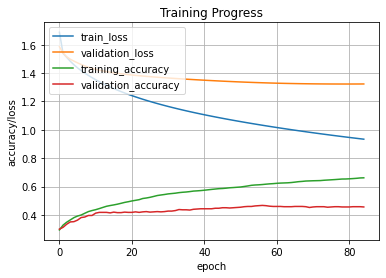

In [18]:
# Get linear model and compile
tf.keras.backend.clear_session()
model = get_linear_classifier(rn50)
model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")

# Train 
history = model.fit(training_ds,
                 validation_data=validation_ds,
                 epochs=100,
                 callbacks=[early_stopper])
plot_progress(history)

In [19]:
_, acc = model.evaluate(validation_ds)
print('Validation accuracy:', round(acc*100, 2))

9/9 [==============================] - 1s 159ms/step - loss: 1.3230 - accuracy: 0.4564
Validation accuracy: 45.64


For a minimal implementation the scores aren't that bad. 